In [49]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [50]:
class DatasetClass(Dataset):
    def __init__(self, num_samples=300, noise_std=0.8, seed=42):
        np.random.seed(seed)
        self.x = np.sort(np.random.uniform(-3.5, 3.5, num_samples)).astype(np.float32)

        # Complicated nonlinear function
        y = (
            np.sin(7 * self.x ** 3)
            + np.log(np.abs(self.x) + 1) * np.cos(3 * self.x ** 2)
            + np.tanh(self.x ** 4)
        ) * np.exp(-self.x ** 2 / 2) + 0.3 * self.x ** 5

        # Add noise
        y += np.random.normal(0, noise_std, size=self.x.shape)

        self.x = torch.tensor(self.x, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [51]:
class ModelClass(nn.Module):
    def __init__(self, model_block: nn.Sequential):
        super().__init__()
        self.model = model_block

    def forward(self, x):
        return self.model(x)

In [52]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import torch

class TrainClass:
    def __init__(self, model, dataset, optimizer_name="adam", lr=0.01, epochs=30, batch_size=32, test_size=0.2):
        self.model = model
        self.epochs = epochs
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = self._get_optimizer(optimizer_name, model.parameters(), lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=0.5)
        self.train_loader, self.test_loader = self._split_dataset(dataset, test_size, batch_size)
        self.train_losses = []

    def _get_optimizer(self, name, parameters, lr):
        name = name.lower()
        if name == "adam":
            return torch.optim.Adam(parameters, lr=lr)
        elif name == "sgd":
            return torch.optim.SGD(parameters, lr=lr)
        elif name == "adamw":
            return torch.optim.AdamW(parameters, lr=lr)
        else:
            raise ValueError(f"Unsupported optimizer: {name}")

    def _split_dataset(self, dataset, test_size, batch_size):
        indices = np.arange(len(dataset))
        train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=42)
        train_set = Subset(dataset, train_idx)
        test_set = Subset(dataset, test_idx)
        return (
            DataLoader(train_set, batch_size=batch_size, shuffle=True),
            DataLoader(test_set, batch_size=batch_size, shuffle=False)
        )

    def train(self):
        for epoch in range(1, self.epochs + 1):
            self.model.train()
            total_loss = 0
            for xb, yb in self.train_loader:
                pred = self.model(xb)
                loss = self.loss_fn(pred, yb)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            self.scheduler.step()
            avg_loss = total_loss / len(self.train_loader)
            self.train_losses.append(avg_loss)

            if epoch % 5 == 0 or epoch == 1:
                print(f"Epoch {epoch} | Train Loss: {avg_loss:.6f}")

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        preds, targets = [], []

        with torch.no_grad():
            for xb, yb in self.test_loader:
                pred = self.model(xb)
                loss = self.loss_fn(pred, yb)
                total_loss += loss.item()
                preds.append(pred)
                targets.append(yb)

        final_mse = total_loss / len(self.test_loader)
        print(f"\nFinal Test MSE: {final_mse:.6f}")
        return torch.cat(preds), torch.cat(targets)

In [53]:
import matplotlib.pyplot as plt

class PlotClass:
    @staticmethod
    def loss(train_losses):
        plt.figure(figsize=(8, 4))
        plt.plot(train_losses, label="Train Loss")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.title("Training Loss")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    @staticmethod
    def predictions(model, dataset):
        model.eval()
        with torch.no_grad():
            x_all = dataset.x
            y_true = dataset.y
            y_pred = model(x_all)

        plt.figure(figsize=(10, 4))
        plt.scatter(x_all.numpy(), y_true.numpy(), s=10, label="True", alpha=0.5)
        plt.plot(x_all.numpy(), y_pred.numpy(), color="red", label="Predicted", linewidth=2)
        plt.title("Regression Fit with Noise")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

Epoch 1 | Train Loss: 2131.181129
Epoch 5 | Train Loss: 2195.867790
Epoch 10 | Train Loss: 2003.753860
Epoch 15 | Train Loss: 1877.699554
Epoch 20 | Train Loss: 1980.027115
Epoch 25 | Train Loss: 1735.416748
Epoch 30 | Train Loss: 1702.846405


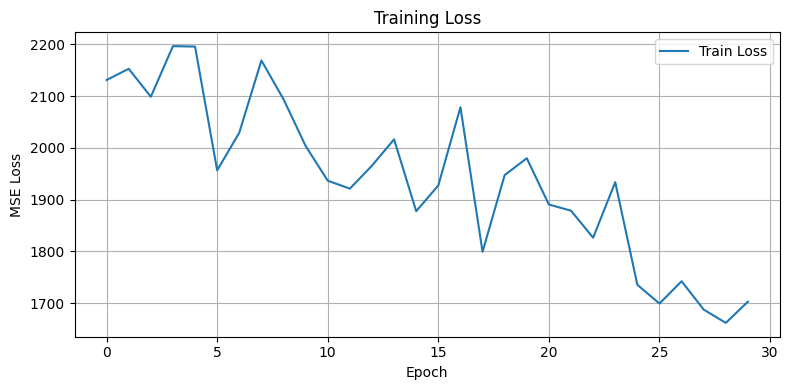

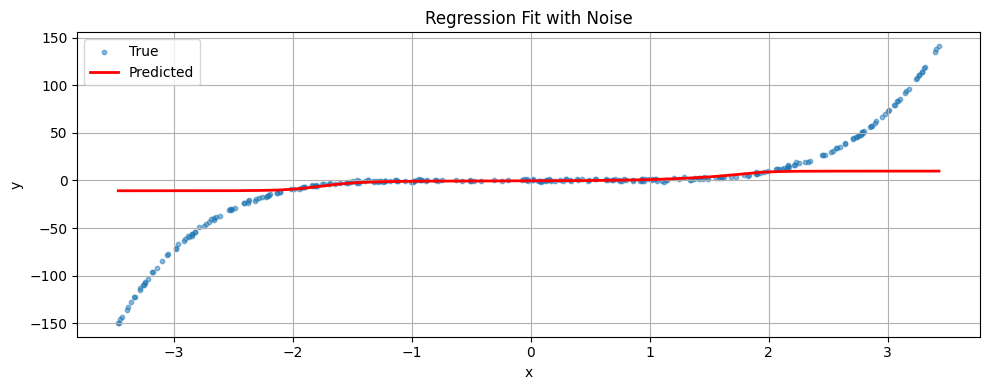


Final Test MSE: 1801.293396


In [57]:
if __name__ == "__main__":
    import torch.nn as nn

    activation = "tanh"     # Options: relu, tanh, leaky_relu, gelu
    optimizer = "adam"      # Options: adam, sgd, adamw
    epochs = 30
    noise = 0.8

    # Define activation instance
    act_map = {
        "relu": nn.ReLU(),
        "tanh": nn.Tanh(),
        "leaky_relu": nn.LeakyReLU(),
        "gelu": nn.GELU()
    }
    act_fn = act_map[activation.lower()]

    # Create your own sequential block
    model_block = nn.Sequential(
        nn.Linear(1, 16),
        act_fn,
        nn.Linear(16, 4),
        act_fn,
        nn.Linear(4, 1)
    )

    dataset = DatasetClass(noise_std=noise)
    model = ModelClass(model_block=model_block)
    trainer = TrainClass(model, dataset, optimizer_name=optimizer, epochs=epochs)
    
    trainer.train()
    PlotClass.loss(trainer.train_losses)
    PlotClass.predictions(model, dataset)
    trainer.evaluate()